# Exercise 5.6.1 

**Easy**: 
1. Simulate an AR(2) process and make forecasts.  
2. Simulate a stationary AR(2) process. Use the `ArmaProcess` function from the `statsmodels` library and simulate the following process:  
y <sub>t</sub> = 0.33y<sub>t−1</sub> + 0.50y<sub>t−2</sub>  
3. For this exercise, generate 1000 samples.


In [1]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

# omd
import importlib
import sys

sys.path.append('../../My-Code/')

import timetools as tt

importlib.reload(tt)

<module 'timetools' from '/home/oliver/Documents/Code/myrepos/TimeSeriesForecastingInPython/MyWork/../../My-Code/timetools.py'>

In [2]:
# simulation of stationary AR(2) process

np.random.seed(42)

ma = np.array([1, 0, 0])
ar = np.array([1, -0.33, -0.50])

ar2 = ArmaProcess(ar=ar, ma=ma).generate_sample(nsample=1000)

Test Statistic                -7.566606e+00
p-value                        2.914516e-11
#Lags Used                     1.000000e+00
Number of Observations Used    9.980000e+02
Critical Value (1%)           -3.436919e+00
Critical Value (5%)           -2.864440e+00
Critical Value (10%)          -2.568314e+00
dtype: float64

The time series is stationary.


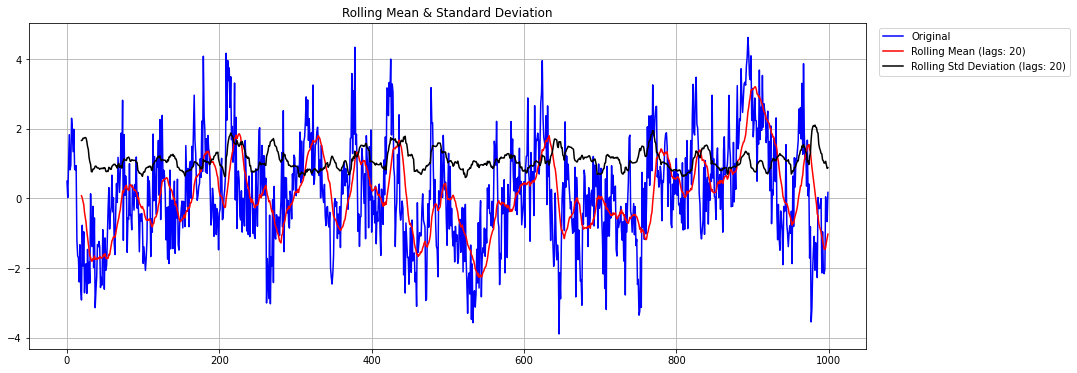

In [3]:
# Plot your simulated autoregressive process.
# Run the ADF test and check if the process is stationary. If not, apply differencing.
tt.adf(pd.Series(ar2))
tt.plot_for_stationary(pd.Series(ar2))

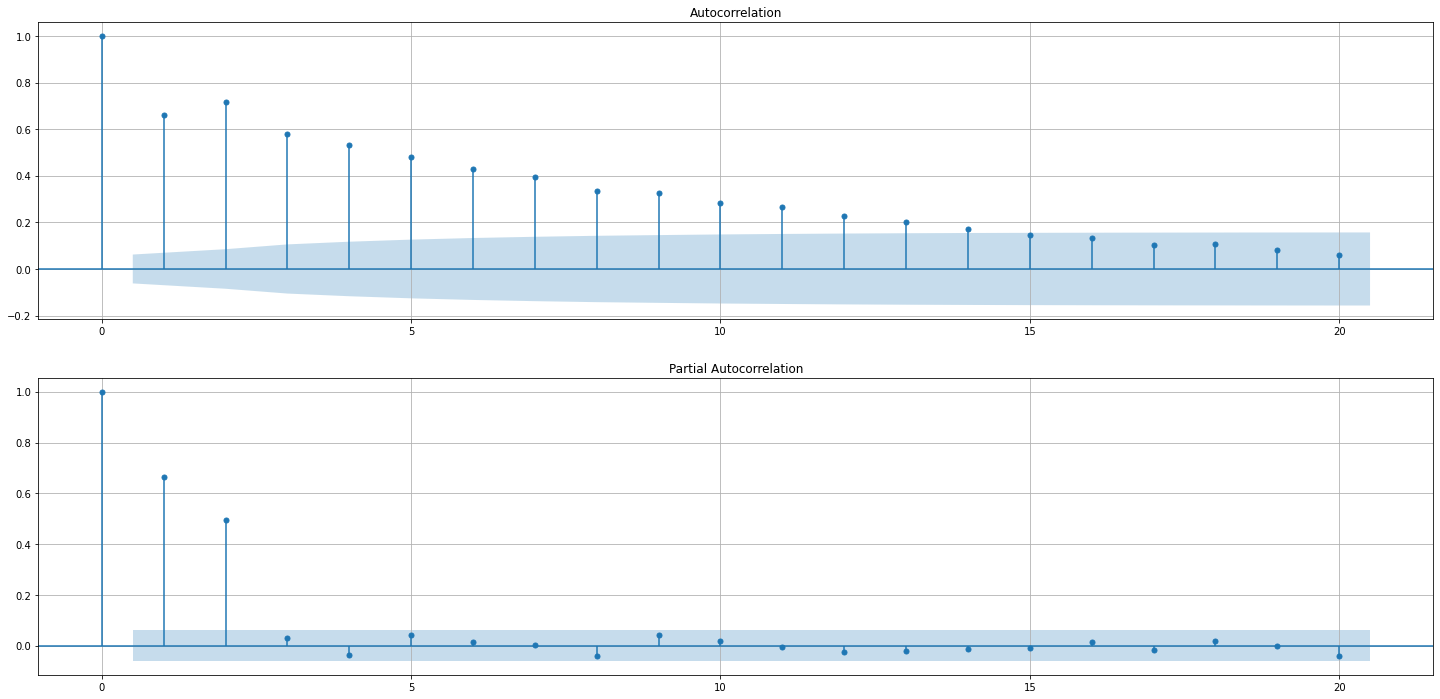

In [4]:
# Plot the ACF. Is it slowly decaying?
# Plot the PACF. Are there significant coefficients after lag 2?

tt.plot_acf_pcf(pd.Series(ar2), num_lag=20)

Yes, the ACF plot is slowly decaying and the PACF plot shows insignificant coefficients.  Hence, it's an autoregressive process.

In [5]:
# Separate your simulated series into a training and test set. Take the first 800
# timesteps for the training set and assign the rest to the test set.

df = pd.DataFrame(ar2, columns=['value'])
train, test = df[:-200], df[-200:]

In [6]:
print(df.shape[0])
print(len(train))
print(len(test))

1000
800
200


Make forecasts over the test set. Use the historical mean method, last value method, and an AR(2) model. Use the `recursive_forecast` function and use a `window` length of 2.

In [7]:
def rolling_forecast(df: pd.DataFrame, train_len: int, horizon: int, window: int, method: str) -> list:
    
    total_len = train_len + horizon
    end_idx = train_len
    
    if method == 'mean':
        pred_mean = []
        
        for i in range(train_len, total_len, window):
            mean = np.mean(df[:i].values)
            pred_mean.extend(mean for _ in range(window))
            
        return pred_mean

    elif method == 'last':
        pred_last_value = []
        
        for i in range(train_len, total_len, window):
            last_value = df[:i].iloc[-1].values[0]
            pred_last_value.extend(last_value for _ in range(window))
            
        return pred_last_value
    
    elif method == 'AR':
        pred_AR = []
        
        for i in range(train_len, total_len, window):
            model = SARIMAX(df[:i], order=(3,0,0))
            res = model.fit(disp=False)
            predictions = res.get_prediction(0, i + window - 1)
            oos_pred = predictions.predicted_mean.iloc[-window:]
            pred_AR.extend(oos_pred)
            
        return pred_AR

In [8]:
pred_df = test.copy()

TRAIN_LEN = len(train)
HORIZON = len(test)
WINDOW = 2

pred_mean = rolling_forecast(df, TRAIN_LEN, HORIZON, WINDOW, 'mean')
pred_last_value = rolling_forecast(df, TRAIN_LEN, HORIZON, WINDOW, 'last')
pred_AR = rolling_forecast(df, TRAIN_LEN, HORIZON, WINDOW, 'AR')

pred_df['pred_mean'] = pred_mean
pred_df['pred_last_value'] = pred_last_value
pred_df['pred_AR'] = pred_AR

pred_df.head()

,value,pred_mean,pred_last_value,pred_AR
800,1.153388,-0.049737,0.461912,0.221317
801,0.095529,-0.049737,0.461912,0.290105
802,0.704340,-0.048056,0.095529,0.587501
803,-0.182079,-0.048056,0.095529,0.256042
804,-0.142412,-0.047287,-0.182079,0.280298


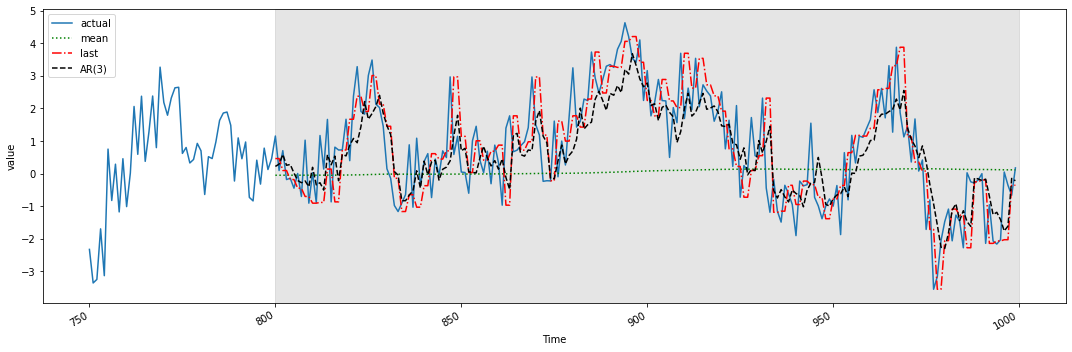

In [9]:
# Plot your forecasts

fig, ax = plt.subplots(figsize=(15,5))

ax.plot(df[750:]['value'], label='actual')
ax.plot(pred_df.pred_mean, 'g:', label='mean')
ax.plot(pred_df.pred_last_value, 'r-.', label='last')
ax.plot(pred_df.pred_AR, 'k--', label='AR(3)')

ax.legend(loc=2)

ax.set_xlabel('Time')
ax.set_ylabel('value')

ax.axvspan(800, 1000, color='#808080', alpha=0.2)

fig.autofmt_xdate()
plt.tight_layout()

In [10]:
# Measure the MSE and identify your champion model

from sklearn.metrics import mean_squared_error

mse_mean = mean_squared_error(pred_df['value'], pred_df['pred_mean'])
mse_last = mean_squared_error(pred_df['value'], pred_df['pred_last_value'])
mse_AR = mean_squared_error(pred_df['value'], pred_df['pred_AR'])

print(mse_mean, mse_last, mse_AR)

3.0882016808214443 1.2111519051869672 0.9691013344906326


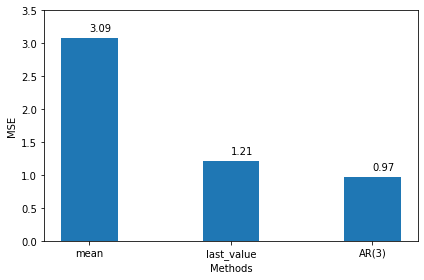

In [11]:
# Plot your MSEs in a bar plot

fig, ax = plt.subplots()

ax.bar(
    ['mean', 'last_value', 'AR(3)'], 
    [mse_mean, mse_last, mse_AR], 
    width=0.4)

ax.set_xlabel('Methods')
ax.set_ylabel('MSE')
ax.set_ylim(0, 3.5)

ax.text(y=mse_mean+0.1, x=0, s=round(mse_mean, 2))
ax.text(y=mse_last+0.1, x=1, s=round(mse_last, 2))
ax.text(y=mse_AR+0.1, x=2, s=round(mse_AR, 2))

plt.tight_layout()